In [7]:
# from load_data import load_and_process_data
import pandas as pd
from transformers import AutoTokenizer, RobertaModel
import torch
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [8]:
#data processing
import pandas as pd
from transformers import AutoTokenizer, RobertaModel
import torch
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df = pd.read_csv('BPD_CLEAN_trans.csv', delimiter=';', on_bad_lines="skip")

df['Q15'] = df['Q15'].replace({'yes': 1, 'no': 0})
df.dropna(subset=['Q15'], inplace=True)
analyzing_columns = [
    "Q14_1", "Q14_2", "Q14_3", "Q14_4", "Q14_5", "Q14_6", "Q14_7", "Q14_8",
    "Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8", "Q9", "Q10",
    "Q17_1", "Q17_2", "Q17_3", "Q17_4", "Q17_6", "Q17_8", "Q17_9", "Q17_17", "Q17_18"
]

def concatenate_texts(row, columns):
    return ' '.join(str(row[col]) for col in columns if not pd.isna(row[col]))


df['combined_text'] = df.apply(concatenate_texts, columns=analyzing_columns, axis=1)
open_questions =  ["Q17_1", "Q17_2", "Q17_3", "Q17_4", "Q17_6", "Q17_8", "Q17_9", "Q17_17", "Q17_18"]
test_questions = [ "Q14_1", "Q14_2", "Q14_3", "Q14_4", "Q14_5", "Q14_6", "Q14_7", "Q14_8"]
df['open_questions'] =  df.apply(concatenate_texts, columns=open_questions, axis=1)
df['test_questions'] = df.apply(concatenate_texts, columns= test_questions, axis=1)
labels=df['Q15'] 
combined_texts = df[analyzing_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
open_questions = df[open_questions].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
test_questions = df[test_questions].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

preprocessed=combined_texts[1:].tolist()

open_questions_processed = open_questions[1:].tolist()
test_questions_processed = test_questions[1:].tolist()


type(labels)

labels=labels[1:].tolist()
#print the size after processing
print(len(preprocessed))
print(len(labels))

378
378


In [10]:
#CROSS VAL OPTION I
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, AdamW
import torch
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold

#  hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.25
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
base_model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion", low_cpu_mem_usage=True)

inputs = tokenizer(preprocessed, padding=True, truncation=True, return_tensors="pt", max_length=512)
with torch.no_grad():
    outputs = base_model(**inputs, output_hidden_states=True)
embeddings = outputs.hidden_states[-1]
all_data = np.asarray(embeddings).reshape(-1, 512*768) 

skf = RepeatedStratifiedKFold(n_splits=5,  n_repeats=3, random_state=1 )
print('K fold')
scores = []
accuracy_scores = []
all_predictions = np.zeros(len(labels))
rocs= []
recalls= []
for train_index, test_index in skf.split(all_data, labels):
    print('At the begining')
    X_train, X_test = all_data[train_index], all_data[test_index]
    y_train, y_test = np.array(labels)[train_index], np.array(labels)[test_index]
    
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)

    

    clf = SVC(class_weight={0:1,1:10}, kernel='rbf', gamma='scale', decision_function_shape='ovr', verbose=True, C=1)
    print('Model created')
   

    clf.fit(X_train, y_train)
    # cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
    y_pred = clf.predict(X_test)
      
    all_predictions[test_index] = y_pred 
    print("Predictions for this fold:", y_pred)
    score = f1_score(y_test, y_pred, average='binary')
    accuracy= accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred=y_pred)
    if len(np.unique(y_test)) > 1:  
        roc_auc = roc_auc_score(y_test, y_pred)
        rocs.append(roc_auc)
        print(f'ROC AUC for this fold: {roc_auc}')
    else:
        print("ROC AUC not defined for this fold due to lack of both classes.")
    scores.append(score)
    accuracy_scores.append(accuracy)
    recalls.append(recall)
    print(f'Fold recall: {recall}')
    print(f'Fold f1: {score}')
    print(f'Fold accuracy: {accuracy}')

average_f1 = np.mean(scores)
average_accuracy = np.mean(accuracy)
print(f'Average recall across all folds: {np.mean(recalls)}')
print(f'Average roc across all folds: {np.mean(rocs)}')
print(f'Average f1 across all folds: {average_f1}')
print(f'Average accuracy across all folds: {average_accuracy}')


K fold
At the begining
Model created
[LibSVM]*.*
optimization finished, #iter = 337
obj = -288.057019, rho = -0.533280
nSV = 260, nBSV = 206
Total nSV = 260
Predictions for this fold: [1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0
 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 0
 1 1]
ROC AUC for this fold: 0.7279411764705881
Fold recall: 0.75
Fold f1: 0.35294117647058826
Fold accuracy: 0.7105263157894737
At the begining
Model created
[LibSVM]*.*
optimization finished, #iter = 310
obj = -257.060014, rho = -0.675966
nSV = 238, nBSV = 189
Total nSV = 238
Predictions for this fold: [1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1
 0 0]
ROC AUC for this fold: 0.5099502487562189
Fold recall: 0.3333333333333333
Fold f1: 0.18181818181818182
Fold accuracy: 0.6447368421052632
At the begining
Model created
[LibSVM].*
optimization finished, #it

In [ ]:
#SVR model
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Example if your labels are already continuous scores
# If labels are not continuous scores, you'll need to adjust them first.

# Tokenization and model embedding code remains the same if using embeddings as features
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
base_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")

inputs = tokenizer(preprocessed, padding=True, truncation=True, return_tensors="pt", max_length=512)
with torch.no_grad():
    outputs = base_model(**inputs, output_hidden_states=True)
embeddings = outputs.hidden_states[-1][:,0,:].detach().numpy()

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

# Fit SVR
regressor = SVR()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Evaluate with Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# To calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")


In [21]:
#final model 
from sklearn.model_selection import cross_val_score
import joblib 

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")

inputs = tokenizer(preprocessed, padding=True, truncation=True, return_tensors="pt", max_length=512)
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
embeddings = outputs.hidden_states[-1][:,0,:].detach().numpy()

clf = SVC()
clf.fit(embeddings, labels)

# Save model and tokenizer
model.save_pretrained('./final_roberta_model')
tokenizer.save_pretrained('./final_roberta_tokenizer')
clf_path = "./final_svc_model.sav"
joblib.dump(clf, clf_path)

print("Model trained and saved.")


KeyboardInterrupt: 

In [26]:
#CROS VALIDATION for graph representations
all_predictions = []

for train_index, test_index in skf.split(preprocessed, labels):
    X_train, X_test = all_data[train_index], all_data[test_index]
    y_train, y_test = np.array(labels)[train_index], np.array(labels)[test_index]
    
    clf = SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    all_predictions.extend(y_pred.tolist())




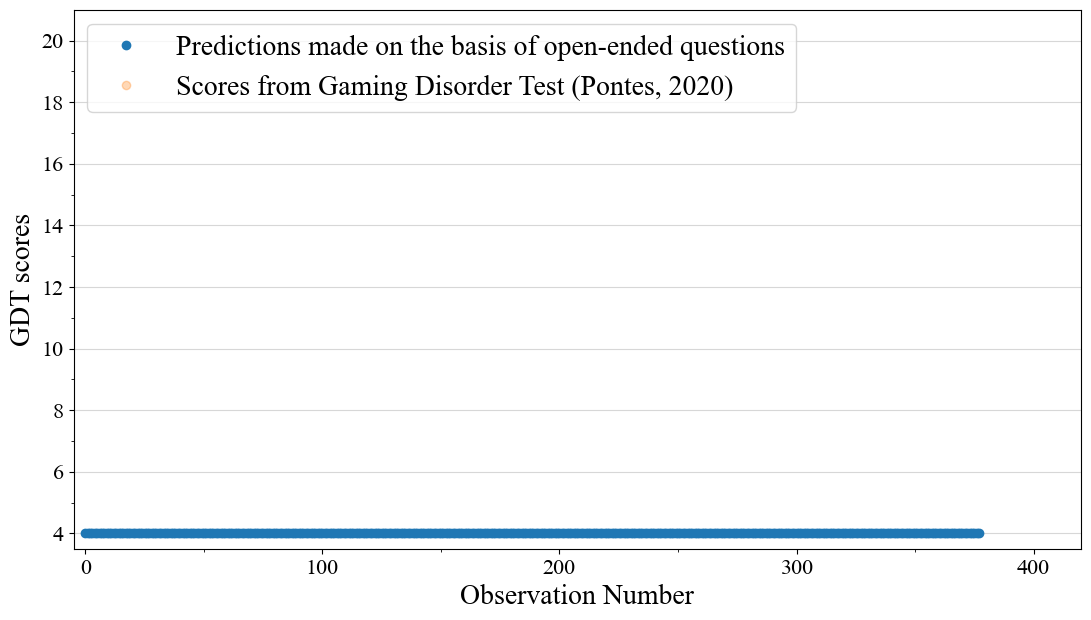

In [27]:
#graph representations
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


model_pred = all_predictions
y_main_true = labels

def plot_results(prediction, true_values):
    plt.rcParams["font.family"] = "Times New Roman"
    
    prediction = [int(item) if int(item) >= 4 else 4 for item in prediction]
    prediction = [int(item) if int(item) <= 20 else 20 for item in prediction]
    true_values = [int(item) for item in true_values]

    answers_tuples = [(y, res) for y, res in zip(true_values, prediction)]
    sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

    sorted_results = [x[1] for x in sorted_tuples]

    true_values_sorted = [x[0] for x in sorted_tuples]
    prediction_sorted = [item for item in sorted_results]

    plt.figure(figsize=(13, 7))
    ax = plt.axes()

    ax.set_ylim(3.5, 21)
    ax.set_yticks(range(4, 21, 2))
    ax.set_yticks(range(4, 21, 1), minor=True)

    ax.grid(True, which='major', axis='y', alpha=0.5)
    ax.set_xlim(-5, 420)
    ax.set_xticks(range(0, 440, 100))
    ax.set_xticks(range(0, 440, 50), minor=True)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=12)

    plt.xlabel('Observation Number', fontsize=20)
    plt.ylabel('GDT scores', fontsize=20)
    
    plt.plot(range(len(prediction_sorted)), prediction_sorted, 'o', label="Predictions made on the basis of open-ended questions")
    plt.plot(range(len(true_values_sorted)), true_values_sorted, 'o', alpha=0.3, label='Scores from Gaming Disorder Test (Pontes, 2020)')
    plt.legend(loc='upper left', fontsize=20)
    plt.show()

plot_results(model_pred, y_main_true)


In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(open_questions_processed)), open_questions_processed, color='blue', alpha=0.5, label='Open Questions')
plt.scatter(range(len(test_questions_processed)), test_questions_processed, color='orange', alpha=0.5, label='Test Questions')

plt.title('Comparison of Response Lengths')
plt.xlabel('Index of Respondents')
plt.ylabel('Length of Responses')
plt.legend()
plt.show()

/Users/apple/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
